In [11]:
import numpy as np
import pandas as pd
import seaborn as sbn
import pickle as pkl
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log


In [2]:
# with open("./data/train_data.pkl") as infile:
#     train_data = pkl.load(infile)

with open("./data/train/train_data.pkl") as infile:
    train_data = pkl.load(infile)


In [19]:
# train_data.columns.values

In [3]:
columns = ['date', 'B365H', 'B365D', 'B365A', 'match_id', 'home_team', 'away_team', 
           'winner', 'minute', 'H_Goal', 'A_Goal']
train_data = train_data[columns]

In [4]:
train_data.shape

(183535, 11)

In [36]:
# train_data.match_id.value_counts()

In [42]:
# train_data[(train_data['match_id']==1510566245714) & (train_data['minute']>=45)]

In [5]:
train_data.drop_duplicates(inplace=True, keep='first')

In [6]:
# train_data.match_id.value_counts()

In [7]:
X = train_data.drop(['winner', 'date', 'match_id', 'home_team', 'away_team'], axis=1)
Y = train_data['winner']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

## Support Vector Classifier

In [92]:
svc = svm.SVC(probability=True)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
y_pred = svc.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = svc.predict_proba(X_test)

## Logistic Regression

In [85]:
lr = LogisticRegression(n_jobs=-1,multi_class='multinomial',solver='lbfgs')
lr.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [86]:
y_pred = lr.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)

y_prob = lr.predict_proba(X_test)

0.654763872816


## Evaluation Environment 

In [87]:
y_prob = pd.DataFrame(y_prob, columns=[-1, 0, 1])

y_prob = y_prob.round(1)

y_prob['label'] = y_test.reset_index(drop=True)

### 1. Eval model for Home win

In [88]:
y_prob[1].value_counts()

vals = sorted(y_prob[1].unique())

y_col = []

for i in vals:
    tot_len = y_prob[(y_prob[1] == i)].shape[0]
    matching_len = y_prob[(y_prob[1] == i) & (y_prob['label'] == 1)].shape[0]
    y_col.append(matching_len*1.0/tot_len)
#     print i, matching_len*1.0/tot_len

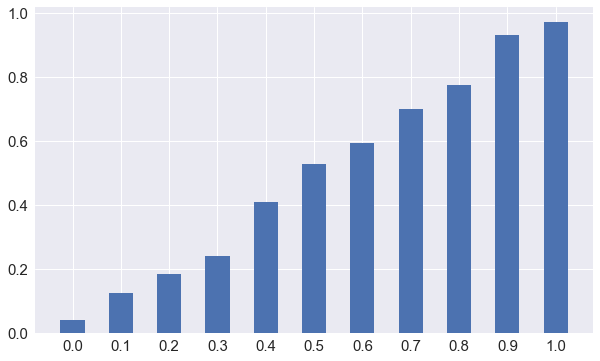

In [89]:
plt.figure(figsize=(10,6))
plt.bar(vals, y_col, width=0.05)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 2. Eval model for Away win

In [90]:
# y_prob[1].value_counts()
label = -1
vals = sorted(y_prob[label].unique())

y_col = []

for i in vals:
    tot_len = y_prob[(y_prob[label] == i)].shape[0]
    matching_len = y_prob[(y_prob[label] == i) & (y_prob['label'] == label)].shape[0]
    y_col.append(matching_len*1.0/tot_len)

# for i, j, in zip(vals, y_col):
#     print i, j


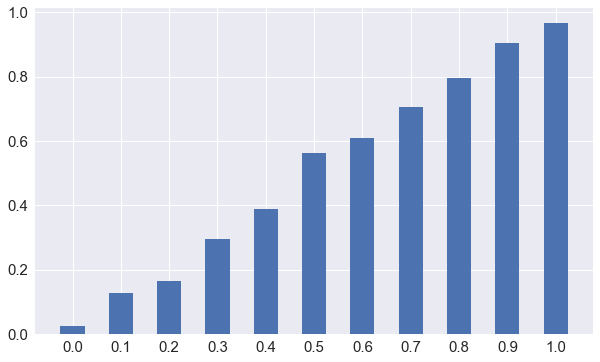

In [91]:
plt.figure(figsize=(10,6))
plt.bar(vals, y_col, width=0.05)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### 3. Eval model for Draw

In [92]:
label = 0
vals = sorted(y_prob[label].unique())

y_col = []

for i in vals:
    tot_len = y_prob[(y_prob[label] == i)].shape[0]
    matching_len = y_prob[(y_prob[label] == i) & (y_prob['label'] == label)].shape[0]
    y_col.append(matching_len*1.0/tot_len)

In [93]:
print vals
# for i, j in zip(vals,y_col):
#     print i,j

[0.0, 0.10000000000000001, 0.20000000000000001, 0.29999999999999999, 0.40000000000000002, 0.5]


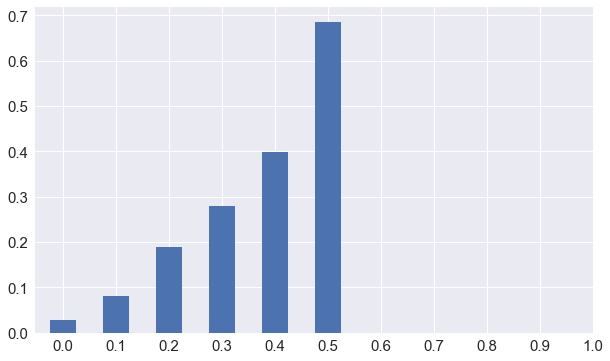

In [94]:
plt.figure(figsize=(10,6))
plt.bar(vals, y_col, width=0.05)
plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=15)
plt.yticks(fontsize=15)
plt.show()